In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import emd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [80]:
df = pd.read_csv('./../data/weather_dataset_preprocesado.csv')

In [81]:
# # take only the 50% of the data
# df = df[:int(len(df)//2)]

In [82]:
target_column = 'T (degC)'
target_index = 'datetime'
load = df[target_column]
time = df[target_index]
x_label = 'Time'
y_label = 'Temperature (°C)'

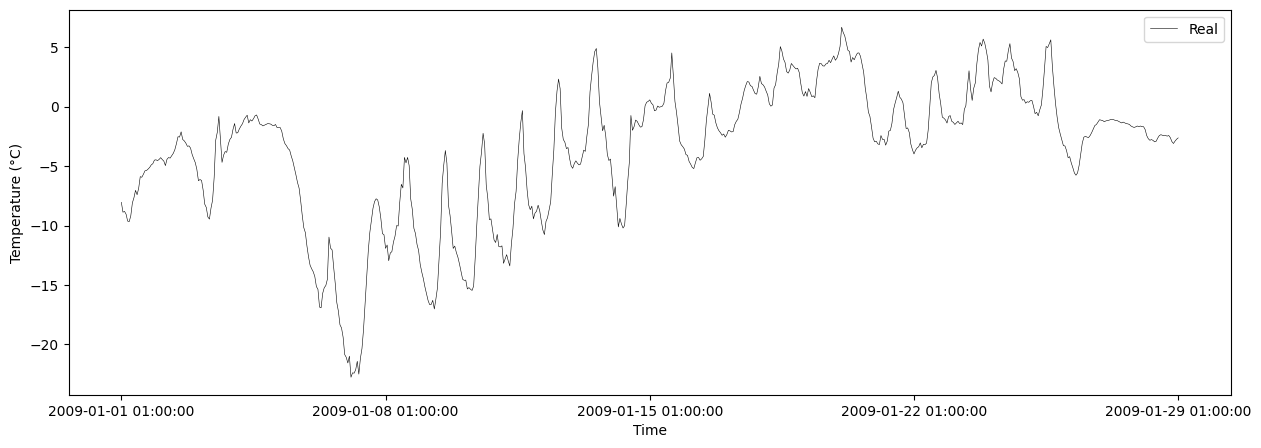

In [83]:
plt.figure(figsize=(15, 5))
plt.plot(time[:673], load[:673], color='k', label='Real', linewidth=0.4)
plt.xticks(np.arange(0, 673, step=168))
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.legend()
plt.show()

In [84]:
train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]

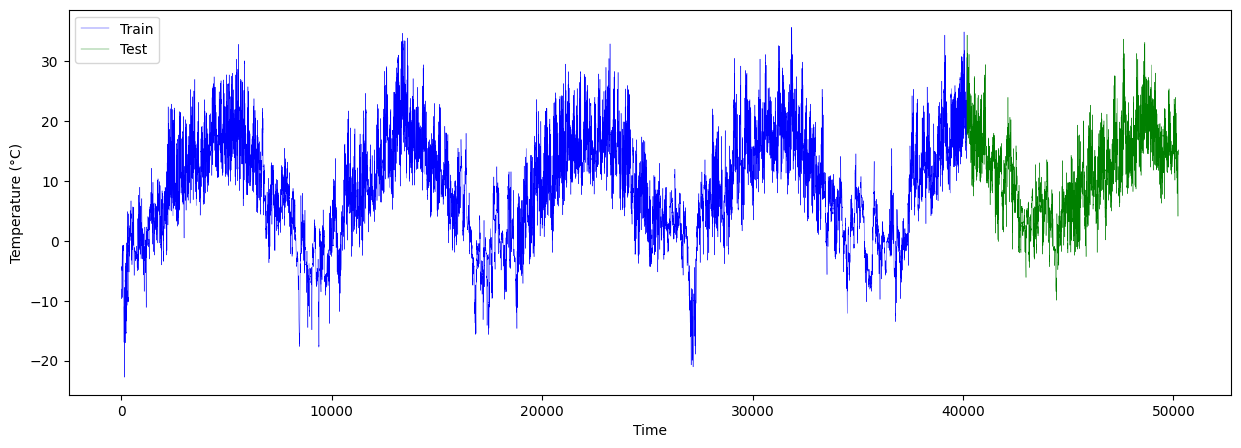

In [85]:
plt.figure(figsize=(15, 5))
plt.plot(train, label='Train', color='b', linewidth=0.3)
plt.plot(test, label='Test', color='g', linewidth=0.3)
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.legend()
plt.show()

In [86]:
df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)

for i in range(1, 4):
    df_train["lag{}".format(i)] = df_train[target_column].shift(i)
    df_test["lag{}".format(i)] = df_test[target_column].shift(i)

df_train = df_train.bfill().drop(columns=[target_column])
df_test = df_test.bfill().drop(columns=[target_column])

,imf_eemd_1,imf_eemd_2,imf_eemd_3,imf_eemd_4,imf_eemd_5,imf_eemd_6,imf_eemd_7,imf_eemd_8,imf_eemd_9,imf_eemd_10
0,6.525236,1.382087,-0.270611,-4.669248,-0.710677,0.872901,-1.254168,-3.283874,-11.234755,3.513210
1,3.596465,3.562151,-0.387929,-4.576894,-0.642314,0.899567,-1.262449,-3.277702,-11.232609,3.513605
2,-2.965093,2.845421,-0.375461,-4.405260,-0.569141,0.926183,-1.270631,-3.271491,-11.230454,3.514000
3,-2.394618,-0.682258,-0.292336,-4.157711,-0.491313,0.952732,-1.278714,-3.265242,-11.228290,3.514395
4,-1.722456,-3.206626,-0.167790,-3.838345,-0.408983,0.979195,-1.286697,-3.258955,-11.226117,3.514790
...,...,...,...,...,...,...,...,...,...,...
40174,0.858289,-1.564942,-0.509724,0.686137,2.660534,-1.884448,0.168675,1.351457,11.579389,6.758597
40175,-3.290930,-4.227464,-1.690079,0.678164,2.651805,-1.881525,0.167778,1.349529,11.579588,6.758357
40176,-3.384596,-5.792574,-2.447569,0.661898,2.637573,-1.877633,0.167009,1.347562,11.579778,6.758116
40177,10.941909,-6.209164,-2.695552,0.638083,2.617970,-1.872782,0.166368,1.345558,11.579959,6.757876


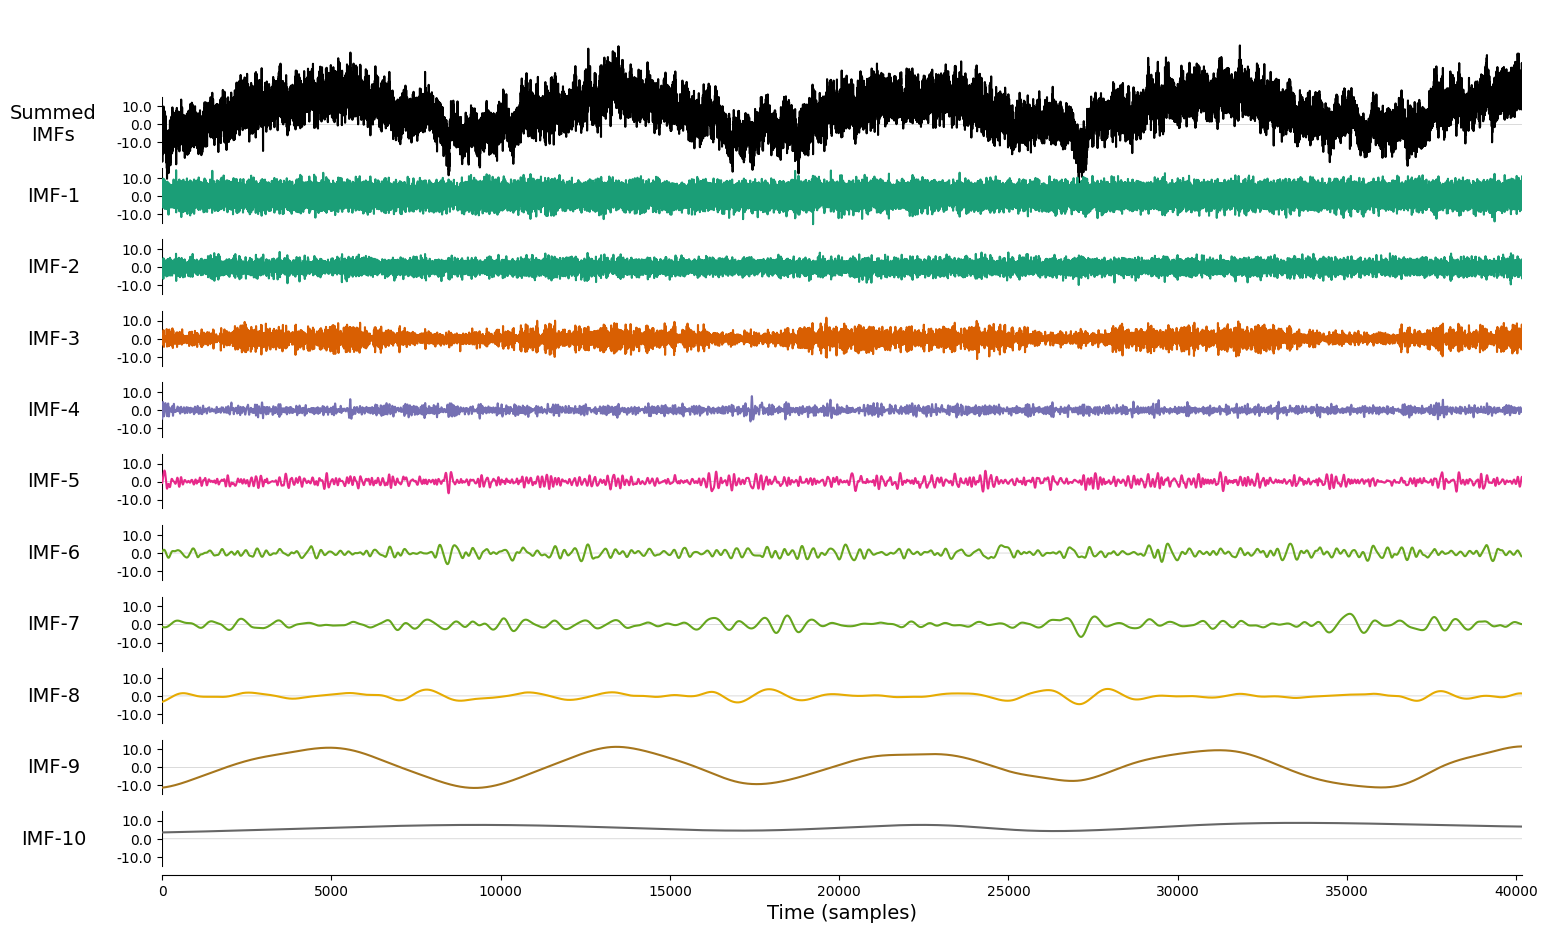

In [87]:
# EEMD
imf_eemd = emd.sift.ensemble_sift(np.array(train), nensembles=4, nprocesses=6, ensemble_noise=1, imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf_eemd)
imf_eemd_df = pd.DataFrame(data=imf_eemd)
imf_eemd_df.columns = ['imf_eemd_{}'.format(i + 1) for i in range(0, imf_eemd.shape[1])]
display(imf_eemd_df)

In [88]:
# Normalización y preparación de datos para LSTM
def prepare_data(series):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(series.values.reshape(-1, 1))
    
    X, y = [], []
    for i in range(1, len(scaled_data)):
        X.append(scaled_data[i-1:i, 0])
        y.append(scaled_data[i, 0])
        
    return np.array(X), np.array(y), scaler

In [91]:
# Parámetros del modelo
c = 10
d = 1
epochs = 8
test_length = len(test)
verbose = 2

In [92]:
test_length

10045

In [93]:
# Preparar los datos
imf1_eemd_lstm_X, imf1_eemd_lstm_y, scaler1 = prepare_data(imf_eemd_df['imf_eemd_1'])
imf1_eemd_lstm_X = df_train.values.reshape((df_train.shape[0], 1, df_train.shape[1]))

model1 = Sequential()
model1.add(LSTM(c, activation='relu', input_shape=(imf1_eemd_lstm_X.shape[1], imf1_eemd_lstm_X.shape[2])))
model1.add(Dense(d))
model1.compile(optimizer='adam', loss='mse')

model1.fit(imf1_eemd_lstm_X, imf_eemd_df['imf_eemd_1'].values, epochs=epochs, verbose=verbose)

Epoch 1/8


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1256/1256 - 3s - 2ms/step - loss: 13.9386
Epoch 2/8
1256/1256 - 1s - 1ms/step - loss: 13.9150
Epoch 3/8
1256/1256 - 1s - 975us/step - loss: 13.9133
Epoch 4/8
1256/1256 - 1s - 980us/step - loss: 13.9090
Epoch 5/8
1256/1256 - 1s - 970us/step - loss: 13.9072
Epoch 6/8
1256/1256 - 1s - 1ms/step - loss: 13.9072
Epoch 7/8
1256/1256 - 1s - 980us/step - loss: 13.9043
Epoch 8/8
1256/1256 - 1s - 989us/step - loss: 13.9019
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [95]:
# Preparar los datos
imf2_eemd_lstm_X, imf2_eemd_lstm_y, scaler2 = prepare_data(imf_eemd_df['imf_eemd_2'])
imf2_eemd_lstm_X = df_train.values.reshape((df_train.shape[0], 1, df_train.shape[1]))

model2 = Sequential()
model2.add(LSTM(c, activation='relu', input_shape=(imf2_eemd_lstm_X.shape[1], imf2_eemd_lstm_X.shape[2])))
model2.add(Dense(d))
model2.compile(optimizer='adam', loss='mse')

model2.fit(imf1_eemd_lstm_X, imf_eemd_df['imf_eemd_2'].values, epochs=epochs, verbose=verbose)

Epoch 1/8


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1256/1256 - 3s - 2ms/step - loss: 4.7882
Epoch 2/8
1256/1256 - 1s - 1ms/step - loss: 4.7408
Epoch 3/8
1256/1256 - 1s - 1ms/step - loss: 4.7305
Epoch 4/8
1256/1256 - 1s - 1ms/step - loss: 4.7226
Epoch 5/8
1256/1256 - 1s - 1ms/step - loss: 4.7161
Epoch 6/8
1256/1256 - 1s - 975us/step - loss: 4.7168
Epoch 7/8
1256/1256 - 1s - 1ms/step - loss: 4.7145
Epoch 8/8
1256/1256 - 1s - 1ms/step - loss: 4.7120


In [96]:
# IMF 3
imf3_eemd_lstm_X, imf3_eemd_lstm_y, scaler3 = prepare_data(imf_eemd_df['imf_eemd_3'])
imf3_eemd_lstm_X = df_train.values.reshape((df_train.shape[0], 1, df_train.shape[1]))

model3 = Sequential()
model3.add(LSTM(c, activation='relu', input_shape=(imf3_eemd_lstm_X.shape[1], imf3_eemd_lstm_X.shape[2])))
model3.add(Dense(d))
model3.compile(optimizer='adam', loss='mse')

model3.fit(imf3_eemd_lstm_X, imf_eemd_df['imf_eemd_3'].values, epochs=epochs, verbose=verbose)

# IMF 4
imf4_eemd_lstm_X, imf4_eemd_lstm_y, scaler4 = prepare_data(imf_eemd_df['imf_eemd_4'])
imf4_eemd_lstm_X = df_train.values.reshape((df_train.shape[0], 1, df_train.shape[1]))

model4 = Sequential()
model4.add(LSTM(c, activation='relu', input_shape=(imf4_eemd_lstm_X.shape[1], imf4_eemd_lstm_X.shape[2])))
model4.add(Dense(d))
model4.compile(optimizer='adam', loss='mse')

model4.fit(imf4_eemd_lstm_X, imf_eemd_df['imf_eemd_4'].values, epochs=epochs, verbose=verbose)

# IMF 5
imf5_eemd_lstm_X, imf5_eemd_lstm_y, scaler5 = prepare_data(imf_eemd_df['imf_eemd_5'])
imf5_eemd_lstm_X = df_train.values.reshape((df_train.shape[0], 1, df_train.shape[1]))

model5 = Sequential()
model5.add(LSTM(c, activation='relu', input_shape=(imf5_eemd_lstm_X.shape[1], imf5_eemd_lstm_X.shape[2])))
model5.add(Dense(d))
model5.compile(optimizer='adam', loss='mse')

model5.fit(imf5_eemd_lstm_X, imf_eemd_df['imf_eemd_5'].values, epochs=epochs, verbose=verbose)

# IMF 6
imf6_eemd_lstm_X, imf6_eemd_lstm_y, scaler6 = prepare_data(imf_eemd_df['imf_eemd_6'])
imf6_eemd_lstm_X = df_train.values.reshape((df_train.shape[0], 1, df_train.shape[1]))

model6 = Sequential()
model6.add(LSTM(c, activation='relu', input_shape=(imf6_eemd_lstm_X.shape[1], imf6_eemd_lstm_X.shape[2])))
model6.add(Dense(d))
model6.compile(optimizer='adam', loss='mse')

model6.fit(imf6_eemd_lstm_X, imf_eemd_df['imf_eemd_6'].values, epochs=epochs, verbose=verbose)

# IMF 7
imf7_eemd_lstm_X, imf7_eemd_lstm_y, scaler7 = prepare_data(imf_eemd_df['imf_eemd_7'])
imf7_eemd_lstm_X = df_train.values.reshape((df_train.shape[0], 1, df_train.shape[1]))

model7 = Sequential()
model7.add(LSTM(c, activation='relu', input_shape=(imf7_eemd_lstm_X.shape[1], imf7_eemd_lstm_X.shape[2])))
model7.add(Dense(d))
model7.compile(optimizer='adam', loss='mse')

model7.fit(imf7_eemd_lstm_X, imf_eemd_df['imf_eemd_7'].values, epochs=epochs, verbose=verbose)

Epoch 1/8


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1256/1256 - 3s - 2ms/step - loss: 6.2555
Epoch 2/8
1256/1256 - 1s - 984us/step - loss: 5.9030
Epoch 3/8
1256/1256 - 1s - 1ms/step - loss: 5.8478
Epoch 4/8
1256/1256 - 1s - 1ms/step - loss: 5.8020
Epoch 5/8
1256/1256 - 1s - 1ms/step - loss: 5.7749
Epoch 6/8
1256/1256 - 1s - 1ms/step - loss: 5.7526
Epoch 7/8
1256/1256 - 1s - 986us/step - loss: 5.7459
Epoch 8/8
1256/1256 - 1s - 1ms/step - loss: 5.7151
Epoch 1/8


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1256/1256 - 2s - 2ms/step - loss: 1.9275
Epoch 2/8
1256/1256 - 1s - 1ms/step - loss: 1.9208
Epoch 3/8
1256/1256 - 1s - 1ms/step - loss: 1.9166
Epoch 4/8
1256/1256 - 1s - 1ms/step - loss: 1.9165
Epoch 5/8
1256/1256 - 1s - 974us/step - loss: 1.9151
Epoch 6/8
1256/1256 - 1s - 1ms/step - loss: 1.9127
Epoch 7/8
1256/1256 - 1s - 1ms/step - loss: 1.9124
Epoch 8/8
1256/1256 - 2s - 1ms/step - loss: 1.9114
Epoch 1/8


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1256/1256 - 3s - 3ms/step - loss: 2.7096
Epoch 2/8
1256/1256 - 2s - 1ms/step - loss: 2.6339
Epoch 3/8
1256/1256 - 2s - 2ms/step - loss: 2.6278
Epoch 4/8
1256/1256 - 1s - 1ms/step - loss: 2.6231
Epoch 5/8
1256/1256 - 1s - 1ms/step - loss: 2.6173
Epoch 6/8
1256/1256 - 1s - 1ms/step - loss: 2.6147
Epoch 7/8
1256/1256 - 1s - 971us/step - loss: 2.6123
Epoch 8/8
1256/1256 - 1s - 983us/step - loss: 2.6095
Epoch 1/8


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1256/1256 - 2s - 2ms/step - loss: 2.6398
Epoch 2/8
1256/1256 - 1s - 1ms/step - loss: 2.5698
Epoch 3/8
1256/1256 - 1s - 1ms/step - loss: 2.5651
Epoch 4/8
1256/1256 - 1s - 1ms/step - loss: 2.5626
Epoch 5/8
1256/1256 - 1s - 887us/step - loss: 2.5623
Epoch 6/8
1256/1256 - 1s - 899us/step - loss: 2.5611
Epoch 7/8
1256/1256 - 1s - 887us/step - loss: 2.5585
Epoch 8/8
1256/1256 - 1s - 924us/step - loss: 2.5589
Epoch 1/8


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1256/1256 - 2s - 2ms/step - loss: 2.6486
Epoch 2/8
1256/1256 - 1s - 996us/step - loss: 2.6026
Epoch 3/8
1256/1256 - 2s - 1ms/step - loss: 2.5965
Epoch 4/8
1256/1256 - 2s - 1ms/step - loss: 2.5936
Epoch 5/8
1256/1256 - 1s - 1ms/step - loss: 2.5918
Epoch 6/8
1256/1256 - 1s - 1ms/step - loss: 2.5914
Epoch 7/8
1256/1256 - 1s - 1ms/step - loss: 2.5894
Epoch 8/8
1256/1256 - 1s - 1ms/step - loss: 2.5898


# Prediction

In [97]:
imf1_eemd_lstm_fc = model1.predict(df_test.values.reshape((df_test.shape[0], 1, df_test.shape[1])))
imf1_eemd_lstm_fc = scaler1.inverse_transform(imf1_eemd_lstm_fc)

314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step


In [104]:
# Predicción para IMF 2
imf2_eemd_lstm_fc = model2.predict(df_test.values.reshape((df_test.shape[0], 1, df_test.shape[1])))
imf2_eemd_lstm_fc = scaler2.inverse_transform(imf2_eemd_lstm_fc)

314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [99]:
# # Predicción para IMF 1
# imf1_eemd_lstm_fc = model1.predict(df_test.values.reshape((df_test.shape[0], 1, df_test.shape[1])))
# imf1_eemd_lstm_fc = scaler1.inverse_transform(imf1_eemd_lstm_fc)

# Predicción para IMF 3
imf3_eemd_lstm_fc = model3.predict(df_test.values.reshape((df_test.shape[0], 1, df_test.shape[1])))
imf3_eemd_lstm_fc = scaler3.inverse_transform(imf3_eemd_lstm_fc)

# Predicción para IMF 4
imf4_eemd_lstm_fc = model4.predict(df_test.values.reshape((df_test.shape[0], 1, df_test.shape[1])))
imf4_eemd_lstm_fc = scaler4.inverse_transform(imf4_eemd_lstm_fc)

# Predicción para IMF 5
imf5_eemd_lstm_fc = model5.predict(df_test.values.reshape((df_test.shape[0], 1, df_test.shape[1])))
imf5_eemd_lstm_fc = scaler5.inverse_transform(imf5_eemd_lstm_fc)

# Predicción para IMF 6
imf6_eemd_lstm_fc = model6.predict(df_test.values.reshape((df_test.shape[0], 1, df_test.shape[1])))
imf6_eemd_lstm_fc = scaler6.inverse_transform(imf6_eemd_lstm_fc)

# Predicción para IMF 7
imf7_eemd_lstm_fc = model7.predict(df_test.values.reshape((df_test.shape[0], 1, df_test.shape[1])))
imf7_eemd_lstm_fc = scaler7.inverse_transform(imf7_eemd_lstm_fc)

314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [102]:
# Función para graficar los valores reales vs predichos
def plot_imf_predictions(imf_number, real_values, predicted_values):
    plt.figure(figsize=(15, 5))
    plt.plot(real_values, label='Real')
    plt.plot(predicted_values, label='Predicted')
    plt.title(f'IMF {imf_number} - Real vs Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

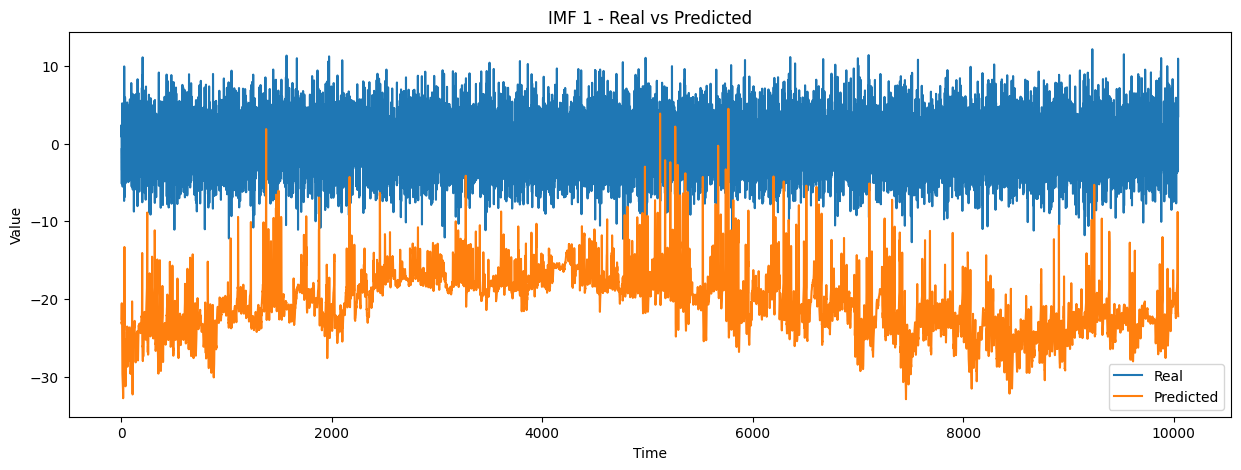

In [103]:
plot_imf_predictions(1, imf_eemd_df['imf_eemd_1'].values[-len(df_test):], imf1_eemd_lstm_fc)

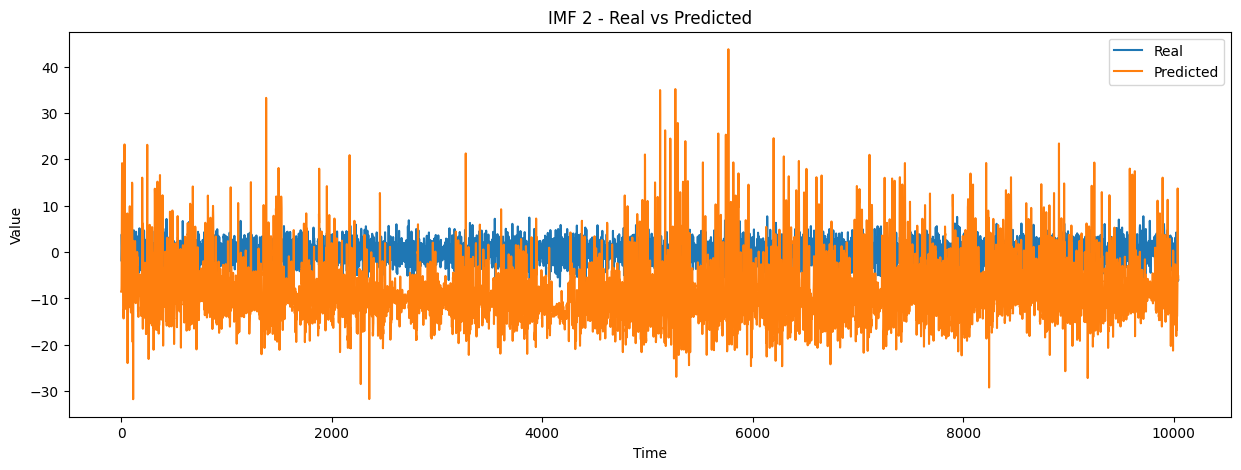

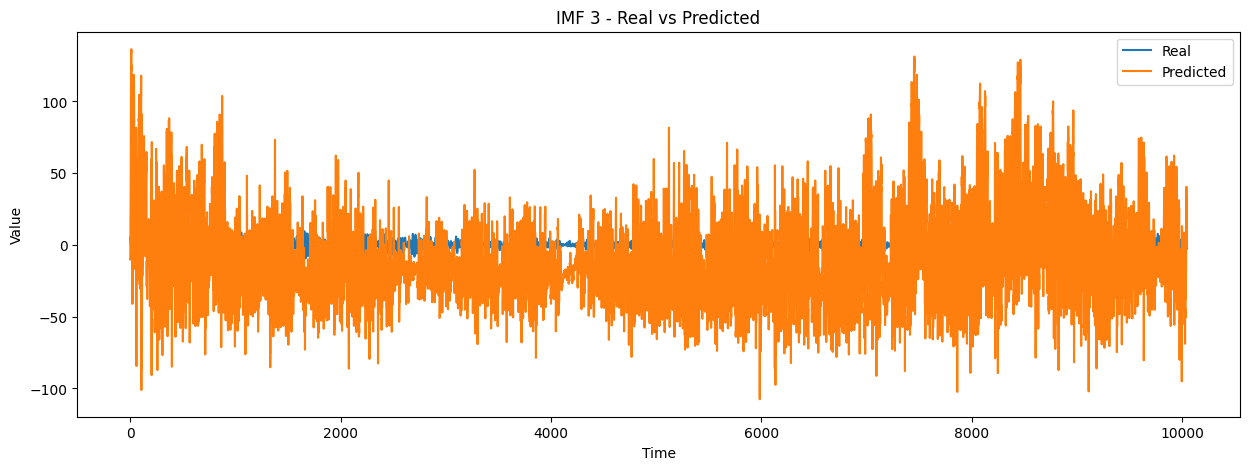

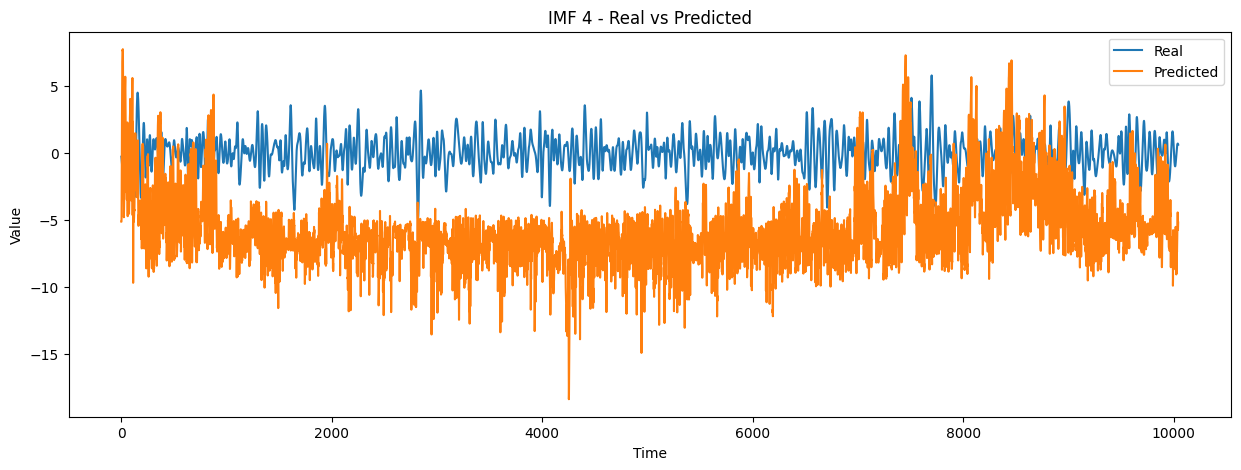

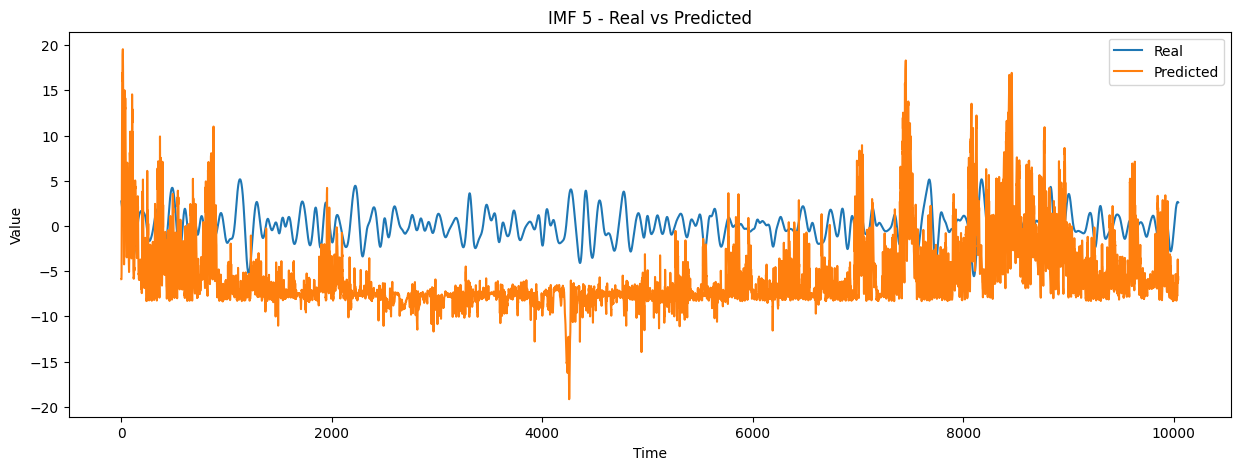

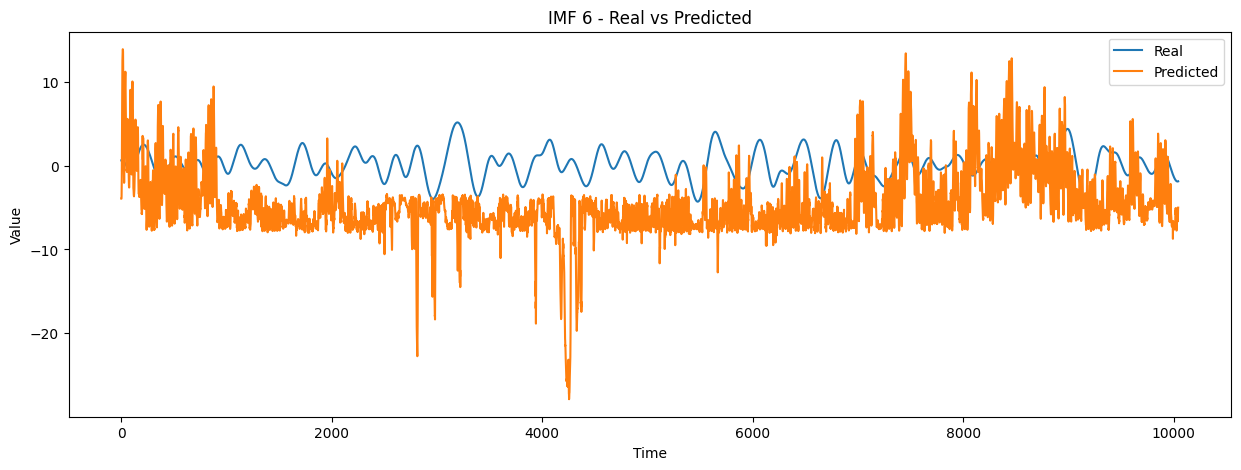

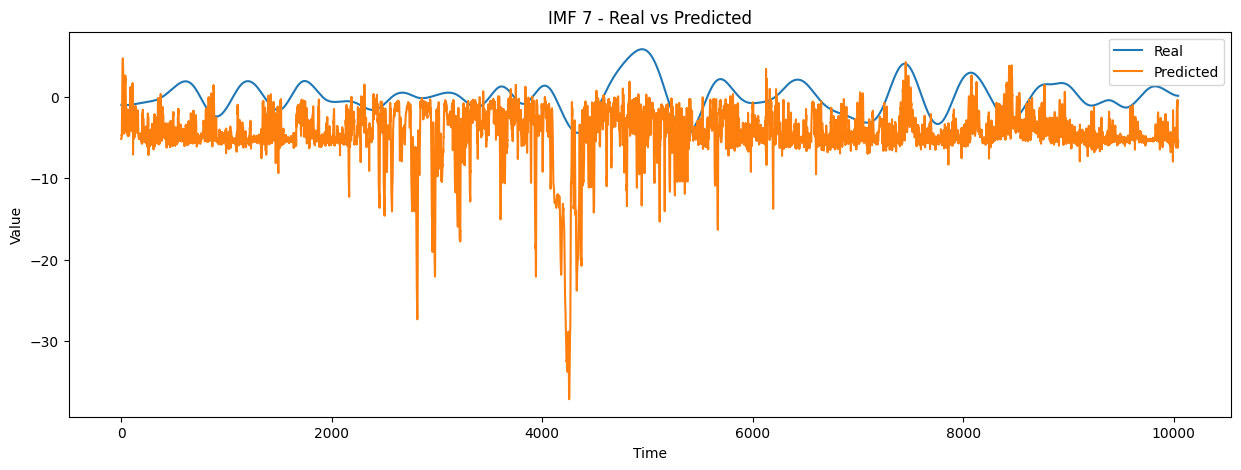

In [105]:
plot_imf_predictions(2, imf_eemd_df['imf_eemd_2'].values[-len(df_test):], imf2_eemd_lstm_fc)
plot_imf_predictions(3, imf_eemd_df['imf_eemd_3'].values[-len(df_test):], imf3_eemd_lstm_fc)
plot_imf_predictions(4, imf_eemd_df['imf_eemd_4'].values[-len(df_test):], imf4_eemd_lstm_fc)
plot_imf_predictions(5, imf_eemd_df['imf_eemd_5'].values[-len(df_test):], imf5_eemd_lstm_fc)
plot_imf_predictions(6, imf_eemd_df['imf_eemd_6'].values[-len(df_test):], imf6_eemd_lstm_fc)
plot_imf_predictions(7, imf_eemd_df['imf_eemd_7'].values[-len(df_test):], imf7_eemd_lstm_fc)

In [ ]:
# # # Entrenamiento de modelos LSTM para IMFs 1 al 7
# # # IMF 1
# # imf1_eemd_lstm_X, imf1_eemd_lstm_y, scaler1 = prepare_data(imf_eemd_df['imf_eemd_1'])
# # imf1_eemd_lstm_X = imf1_eemd_lstm_X.reshape((imf1_eemd_lstm_X.shape[0], 1, imf1_eemd_lstm_X.shape[1]))

# # model1 = Sequential()
# # model1.add(LSTM(c, activation='relu', input_shape=(imf1_eemd_lstm_X.shape[1], imf1_eemd_lstm_X.shape[2])))
# # model1.add(Dense(d))
# # model1.compile(optimizer='adam', loss='mse')
# # model1.fit(imf1_eemd_lstm_X, imf1_eemd_lstm_y, epochs=epochs, verbose=verbose)
# # imf1_eemd_lstm_fc = model1.predict(imf1_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
# # imf1_eemd_lstm_fc = scaler1.inverse_transform(imf1_eemd_lstm_fc)

# # IMF 2
# imf2_eemd_lstm_X, imf2_eemd_lstm_y, scaler2 = prepare_data(imf_eemd_df['imf_eemd_2'])
# imf2_eemd_lstm_X = imf2_eemd_lstm_X.reshape((imf2_eemd_lstm_X.shape[0], 1, imf2_eemd_lstm_X.shape[1]))

# model2 = Sequential()
# model2.add(LSTM(c, activation='relu', input_shape=(imf2_eemd_lstm_X.shape[1], imf2_eemd_lstm_X.shape[2])))
# model2.add(Dense(d))
# model2.compile(optimizer='adam', loss='mse')
# model2.fit(imf2_eemd_lstm_X, imf2_eemd_lstm_y, epochs=epochs, verbose=verbose)
# imf2_eemd_lstm_fc = model2.predict(imf2_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
# imf2_eemd_lstm_fc = scaler2.inverse_transform(imf2_eemd_lstm_fc)

# # IMF 3
# imf3_eemd_lstm_X, imf3_eemd_lstm_y, scaler3 = prepare_data(imf_eemd_df['imf_eemd_3'])
# imf3_eemd_lstm_X = imf3_eemd_lstm_X.reshape((imf3_eemd_lstm_X.shape[0], 1, imf3_eemd_lstm_X.shape[1]))

# model3 = Sequential()
# model3.add(LSTM(c, activation='relu', input_shape=(imf3_eemd_lstm_X.shape[1], imf3_eemd_lstm_X.shape[2])))
# model3.add(Dense(d))
# model3.compile(optimizer='adam', loss='mse')
# model3.fit(imf3_eemd_lstm_X, imf3_eemd_lstm_y, epochs=epochs, verbose=verbose)
# imf3_eemd_lstm_fc = model3.predict(imf3_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
# imf3_eemd_lstm_fc = scaler3.inverse_transform(imf3_eemd_lstm_fc)

# # IMF 4
# imf4_eemd_lstm_X, imf4_eemd_lstm_y, scaler4 = prepare_data(imf_eemd_df['imf_eemd_4'])
# imf4_eemd_lstm_X = imf4_eemd_lstm_X.reshape((imf4_eemd_lstm_X.shape[0], 1, imf4_eemd_lstm_X.shape[1]))

# model4 = Sequential()
# model4.add(LSTM(c, activation='relu', input_shape=(imf4_eemd_lstm_X.shape[1], imf4_eemd_lstm_X.shape[2])))
# model4.add(Dense(d))
# model4.compile(optimizer='adam', loss='mse')
# model4.fit(imf4_eemd_lstm_X, imf4_eemd_lstm_y, epochs=epochs, verbose=verbose)
# imf4_eemd_lstm_fc = model4.predict(imf4_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
# imf4_eemd_lstm_fc = scaler4.inverse_transform(imf4_eemd_lstm_fc)

# # IMF 5
# imf5_eemd_lstm_X, imf5_eemd_lstm_y, scaler5 = prepare_data(imf_eemd_df['imf_eemd_5'])
# imf5_eemd_lstm_X = imf5_eemd_lstm_X.reshape((imf5_eemd_lstm_X.shape[0], 1, imf5_eemd_lstm_X.shape[1]))

# model5 = Sequential()
# model5.add(LSTM(c, activation='relu', input_shape=(imf5_eemd_lstm_X.shape[1], imf5_eemd_lstm_X.shape[2])))
# model5.add(Dense(d))
# model5.compile(optimizer='adam', loss='mse')
# model5.fit(imf5_eemd_lstm_X, imf5_eemd_lstm_y, epochs=epochs, verbose=verbose)
# imf5_eemd_lstm_fc = model5.predict(imf5_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
# imf5_eemd_lstm_fc = scaler5.inverse_transform(imf5_eemd_lstm_fc)

# # IMF 6
# imf6_eemd_lstm_X, imf6_eemd_lstm_y, scaler6 = prepare_data(imf_eemd_df['imf_eemd_6'])
# imf6_eemd_lstm_X = imf6_eemd_lstm_X.reshape((imf6_eemd_lstm_X.shape[0], 1, imf6_eemd_lstm_X.shape[1]))

# model6 = Sequential()
# model6.add(LSTM(c, activation='relu', input_shape=(imf6_eemd_lstm_X.shape[1], imf6_eemd_lstm_X.shape[2])))
# model6.add(Dense(d))
# model6.compile(optimizer='adam', loss='mse')
# model6.fit(imf6_eemd_lstm_X, imf6_eemd_lstm_y, epochs=epochs, verbose=verbose)
# imf6_eemd_lstm_fc = model6.predict(imf6_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
# imf6_eemd_lstm_fc = scaler6.inverse_transform(imf6_eemd_lstm_fc)

# # IMF 7
# imf7_eemd_lstm_X, imf7_eemd_lstm_y, scaler7 = prepare_data(imf_eemd_df['imf_eemd_7'])
# imf7_eemd_lstm_X = imf7_eemd_lstm_X.reshape((imf7_eemd_lstm_X.shape[0], 1, imf7_eemd_lstm_X.shape[1]))

# model7 = Sequential()
# model7.add(LSTM(c, activation='relu', input_shape=(imf7_eemd_lstm_X.shape[1], imf7_eemd_lstm_X.shape[2])))
# model7.add(Dense(d))
# model7.compile(optimizer='adam', loss='mse')
# model7.fit(imf7_eemd_lstm_X, imf7_eemd_lstm_y, epochs=epochs, verbose=verbose)
# imf7_eemd_lstm_fc = model7.predict(imf7_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
# imf7_eemd_lstm_fc = scaler7.inverse_transform(imf7_eemd_lstm_fc)

In [106]:
from pmdarima.arima import auto_arima

imf8_eemd_auto_arima_model = auto_arima(imf_eemd_df['imf_eemd_8'],
                              start_p=1, start_q=1,
                              max_p=5, max_q=5,
                              seasonal=True,
                            #   m=12,  # Periodo de estacionalidad
                              start_P=0, start_Q=0,
                              max_P=5, max_Q=5,
                              d=1, D=1,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)

print(imf8_eemd_auto_arima_model.summary())

Performing stepwise search to minimize aic


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-763607.013, Time=7.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-316593.252, Time=3.35 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=5.45 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=14.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-316571.197, Time=0.99 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=9.66 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-763604.573, Time=9.75 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=25.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=8.86 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-851243.643, Time=22.73 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-851220.982, Time=34.14 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-851244.253, Time=16.44 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-763602.371, Time=13.62 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-851223.606, Time=44.12 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-851242.709, Time=18.10 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-763599.731, Time=16.17 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-851219.291, Time=20.32 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=-834930.492, Time=23.40 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0] intercept
Total fit time: 293.988 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                40179
Model:               SARIMAX(2, 1, 3)   Log Likelihood              425629.127
Date:                Thu, 24 Oct 2024   AIC                        -851244.253
Time:                        16:26:28   BIC                        -851184.046
Sample:                             0   HQIC                       -851225.200
                              - 40179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]


In [107]:
imf9_eemd_auto_arima_model = auto_arima(imf_eemd_df['imf_eemd_9'],
                              start_p=1, start_q=1,
                              max_p=5, max_q=5,
                              seasonal=True,
                            #   m=12,  # Periodo de estacionalidad
                              start_P=0, start_Q=0,
                              max_P=5, max_Q=5,
                              d=1, D=1,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)

imf10_eemd_auto_arima_model = auto_arima(imf_eemd_df['imf_eemd_10'],
                              start_p=1, start_q=1,
                              max_p=5, max_q=5,
                              seasonal=True,
                            #   m=12,  # Periodo de estacionalidad
                              start_P=0, start_Q=0,
                              max_P=5, max_Q=5,
                              d=1, D=1,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)

Performing stepwise search to minimize aic


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-844418.930, Time=7.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-311811.239, Time=2.40 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=16.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=16.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-311297.270, Time=1.51 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=9.44 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-848146.879, Time=30.90 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=19.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-851241.271, Time=37.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-851211.951, Time=14.07 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-851364.614, Time=47.91 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-844413.653, Time=15.46 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-750772.618, Time=94.94 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-851239.155, Time=53.16 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-844327.215, Time=19.71 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-631241.445, Time=54.28 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=nan sec

Best model:  ARIMA(2,1,3)(0,0,0)[0] intercept
Total fit time: 448.413 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-484465.832, Time=22.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-484477.837, Time=4.59 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=6.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-484475.531, Time=15.54 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-483715.099, Time=1.67 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 50.259 seconds


In [108]:
# def plot_imf_predictions(imf_number, real_values, predicted_values):
#     plt.figure(figsize=(10, 6))
#     plt.plot(real_values, label='Real')
#     plt.plot(predicted_values, label='Predicted')
#     plt.title(f'IMF {imf_number} - Real vs Predicted')
#     plt.xlabel('Time')
#     plt.ylabel('Value')
#     plt.legend()
#     plt.show()

# # Función para preparar los datos para auto_arima
# def prepare_arima_data(series):
#     return series.values

In [68]:
def plot_predictions_vs_real(predictions, real_values, imf_number, title_suffix='', xlabel='Time', ylabel='Value', figsize=(12, 5), pred_color='r', real_color='b', pred_linewidth=0.5, real_linewidth=0.4):
    if isinstance(predictions, (list, np.ndarray)):
        predictions = pd.Series(predictions, index=real_values.index)

    plt.figure(figsize=figsize)
    plt.plot(real_values, color=real_color, linewidth=real_linewidth, label=f'IMF {imf_number} Real')
    plt.plot(predictions, color=pred_color, linewidth=pred_linewidth, label=f'IMF {imf_number} Prediction')
    plt.title(f'IMF EEMD #{imf_number} Prediction vs Real Values {title_suffix}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [109]:
imf8_eemd_auto_arima_fc = imf8_eemd_auto_arima_model.predict(n_periods=len(test))
imf9_eemd_auto_arima_fc = imf9_eemd_auto_arima_model.predict(n_periods=len(test))
imf10_eemd_auto_arima_fc = imf10_eemd_auto_arima_model.predict(n_periods=len(test))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-851243.643, Time=20.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-316593.252, Time=3.69 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=5.78 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=14.85 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-316571.197, Time=1.04 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-763604.573, Time=11.00 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=10.87 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-851220.982, Time=40.61 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-851244.253, Time=17.83 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-763602.371, Time=17.06 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-851223.606, Time=60.92 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-851242.709, Time=20.48 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-763599.731, Time=18.42 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-851219.291, Time=23.58 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=-834930.492, Time=27.37 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0] intercept
Total fit time: 294.344 seconds


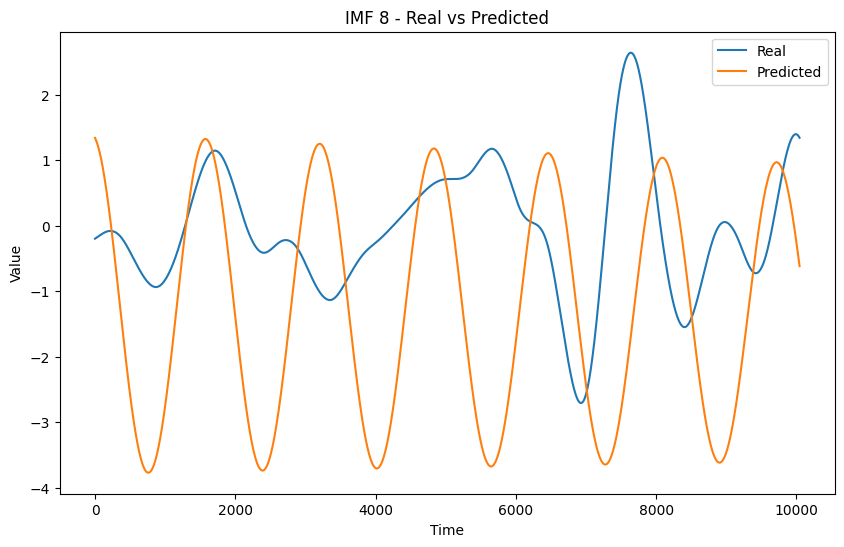

In [118]:
def plot_imf_predictions(imf_number, real_values, predicted_values):
    plt.figure(figsize=(10, 6))
    plt.plot(real_values, label='Real')
    plt.plot(predicted_values, label='Predicted')
    plt.title(f'IMF {imf_number} - Real vs Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    
# Función para preparar los datos para auto_arima
def prepare_arima_data(series):
    return series.values

# IMF 8
imf8_train = prepare_arima_data(imf_eemd_df['imf_eemd_8'])
imf8_model = auto_arima(imf8_train, seasonal=False, trace=True)
imf8_model.fit(imf8_train)

imf8_test = prepare_arima_data(df_test)
imf8_fc = imf8_model.predict(n_periods=len(imf8_test))
plot_imf_predictions(8, imf_eemd_df['imf_eemd_8'].values[-len(df_test):], imf8_fc)

Performing stepwise search to minimize aic


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,2,2)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\mlem

 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-855899.647, Time=8.30 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=inf, Time=19.60 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-855895.378, Time=19.90 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-805602.803, Time=2.11 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-851362.654, Time=28.87 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0] intercept
Total fit time: 101.514 seconds


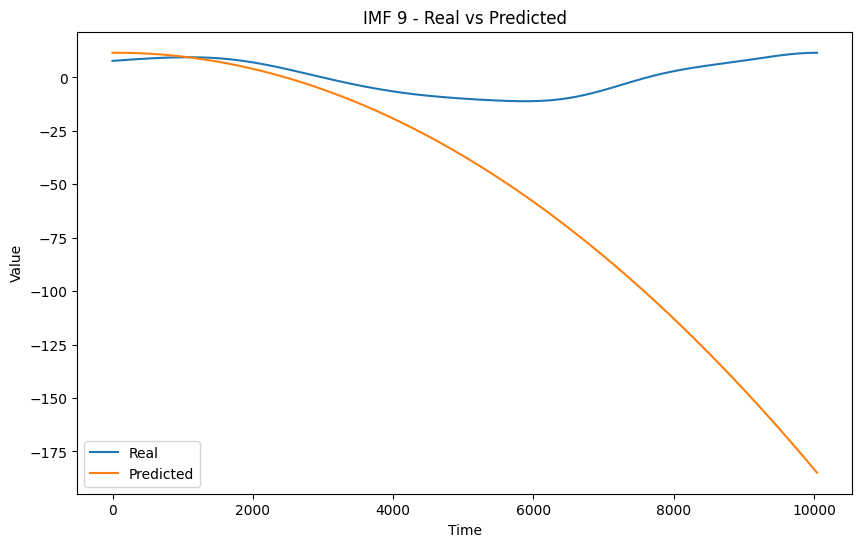

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-857309.020, Time=31.07 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-885418.663, Time=10.37 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-885486.166, Time=15.54 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-885416.631, Time=13.29 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-917826.243, Time=3.83 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-885484.166, Time=15.62 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 89.748 seconds


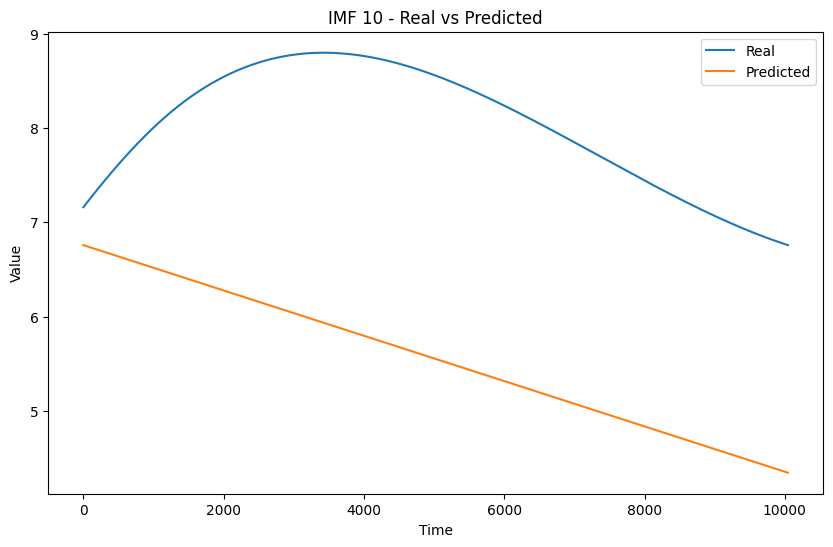

In [119]:
# IMF 9
imf9_train = prepare_arima_data(imf_eemd_df['imf_eemd_9'])
imf9_model = auto_arima(imf9_train, seasonal=False, trace=True)
imf9_model.fit(imf9_train)

imf9_test = prepare_arima_data(df_test)
imf9_fc = imf9_model.predict(n_periods=len(imf9_test))
plot_imf_predictions(9, imf_eemd_df['imf_eemd_9'].values[-len(df_test):], imf9_fc)

# IMF 10
imf10_train = prepare_arima_data(imf_eemd_df['imf_eemd_10'])
imf10_model = auto_arima(imf10_train, seasonal=False, trace=True)
imf10_model.fit(imf10_train)

imf10_test = prepare_arima_data(df_test)
imf10_fc = imf10_model.predict(n_periods=len(imf10_test))
plot_imf_predictions(10, imf_eemd_df['imf_eemd_10'].values[-len(df_test):], imf10_fc)

In [120]:
imf1_eemd_lstm_fc_1 = imf1_eemd_lstm_fc.reshape(-1)
imf2_eemd_lstm_fc_2 = imf2_eemd_lstm_fc.reshape(-1)
imf3_eemd_lstm_fc_3 = imf3_eemd_lstm_fc.reshape(-1)
imf4_eemd_lstm_fc_4 = imf4_eemd_lstm_fc.reshape(-1)
imf5_eemd_lstm_fc_5 = imf5_eemd_lstm_fc.reshape(-1)
imf6_eemd_lstm_fc_6 = imf6_eemd_lstm_fc.reshape(-1)
imf7_eemd_lstm_fc_7 = imf7_eemd_lstm_fc.reshape(-1)

imf_lstm_fc = np.sum([
    imf1_eemd_lstm_fc_1, imf2_eemd_lstm_fc_2, imf3_eemd_lstm_fc_3,
    imf4_eemd_lstm_fc_4, imf5_eemd_lstm_fc_5, imf6_eemd_lstm_fc_6, imf7_eemd_lstm_fc_7,
    imf8_fc, imf9_fc, imf10_fc
], axis=0)

print(imf_lstm_fc.shape)

(10045,)


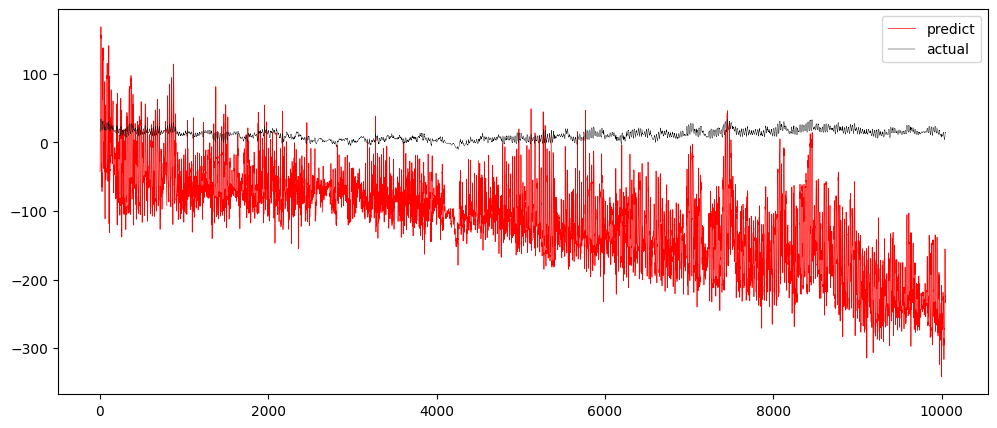

RMSE = 141.0746771299738 
MAE = 125.06661731244064 
MAPE = 113089985243327.31


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [121]:
plt.figure(figsize=(12, 5))
plt.plot(imf_lstm_fc, label='predict', color='r', linewidth=0.5)
plt.plot(test.values, label='actual', color='k', linewidth=0.3)
plt.legend()
plt.show()

RMSE_EEMD_LSTM = mean_squared_error(test, imf_lstm_fc, squared=False)
MAE_EEMD_LSTM = mean_absolute_error(test, imf_lstm_fc)
MAPE_EEMD_LSTM = mean_absolute_percentage_error(test, imf_lstm_fc)

print('RMSE = {}'.format(RMSE_EEMD_LSTM), 
      '\nMAE = {}'.format(MAE_EEMD_LSTM), 
      '\nMAPE = {}'.format(MAPE_EEMD_LSTM))

In [ ]:
plot_predictions_vs_real(imf8_eemd_auto_arima_fc, imf_eemd_df['imf_eemd_8'], imf_number=8)
plot_predictions_vs_real(imf9_eemd_auto_arima_fc, imf_eemd_df['imf_eemd_9'], imf_number=9)
plot_predictions_vs_real(imf10_eemd_auto_arima_fc, imf_eemd_df['imf_eemd_10'], imf_number=10)

In [ ]:
plot_predictions_vs_real(imf1_eemd_lstm_fc, imf_eemd_df['imf_eemd_1'], imf_number=1)

# plot_auto_arima_in_sample_and_real(imf1_eemd_lstm_fc, imf_eemd_df['imf_eemd_1'], imf_number=1)
# plot_auto_arima_in_sample_and_real(imf9_eemd_auto_arima_model, imf_eemd_df['imf_eemd_9'], imf_number=9)
# plot_auto_arima_in_sample_and_real(imf10_eemd_auto_arima_model, imf_eemd_df['imf_eemd_10'], imf_number=10)

In [ ]:
imf1_eemd_lstm_fc.shape

In [ ]:
imf8_eemd_auto_arima_fc.shape

In [ ]:
plot_auto_arima_in_sample_and_real(imf8_eemd_auto_arima_model, imf_eemd_df['imf_eemd_8'], imf_number=8)
plot_auto_arima_in_sample_and_real(imf9_eemd_auto_arima_model, imf_eemd_df['imf_eemd_9'], imf_number=9)
plot_auto_arima_in_sample_and_real(imf10_eemd_auto_arima_model, imf_eemd_df['imf_eemd_10'], imf_number=10)

In [ ]:
plot_auto_arima_prediction(imf9_eemd_auto_arima_model, imf_eemd_df['imf_eemd_9'], imf_number=9)

In [ ]:
imf9_eemd_auto_arima_model.predict_in_sample(n_periods=len(imf_eemd_df['imf_eemd_9'])).plot()
imf_eemd_df['imf_eemd_9'].plot(figsize=(12,5))

In [ ]:
imf10_eemd_auto_arima_model.predict_in_sample(n_periods=len(df)).plot()
df['T (degC)'].plot(figsize=(12,5))

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

imf8_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_8'], order=(2, 1, 0)).fit()
imf8_eemd_arima_fc = imf8_eemd_arima.forecast(steps=len(test))

imf9_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_9'], order=(2, 1, 0)).fit()
imf9_eemd_arima_fc = imf9_eemd_arima.forecast(steps=len(test))

imf10_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_10'], order=(2, 1, 0)).fit()
imf10_eemd_arima_fc = imf10_eemd_arima.forecast(steps=len(test))

In [ ]:
imf1_eemd_lstm_fc_1 = imf1_eemd_lstm_fc.reshape(-1)
imf2_eemd_lstm_fc_2 = imf2_eemd_lstm_fc.reshape(-1)
imf3_eemd_lstm_fc_3 = imf3_eemd_lstm_fc.reshape(-1)
imf4_eemd_lstm_fc_4 = imf4_eemd_lstm_fc.reshape(-1)
imf5_eemd_lstm_fc_5 = imf5_eemd_lstm_fc.reshape(-1)
imf6_eemd_lstm_fc_6 = imf6_eemd_lstm_fc.reshape(-1)
imf7_eemd_lstm_fc_7 = imf7_eemd_lstm_fc.reshape(-1)

imf_lstm_fc = np.sum([
    imf1_eemd_lstm_fc_1, imf2_eemd_lstm_fc_2, imf3_eemd_lstm_fc_3,
    imf4_eemd_lstm_fc_4, imf5_eemd_lstm_fc_5, imf6_eemd_lstm_fc_6, imf7_eemd_lstm_fc_7,
    imf8_eemd_arima_fc, imf9_eemd_arima_fc, imf10_eemd_arima_fc
], axis=0)

print(imf_lstm_fc.shape)

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(imf_lstm_fc, label='predict', color='r', linewidth=0.5)
plt.plot(test.values, label='actual', color='k', linewidth=0.3)
plt.legend()
plt.show()

RMSE_EEMD_LSTM = mean_squared_error(test, imf_lstm_fc, squared=False)
MAE_EEMD_LSTM = mean_absolute_error(test, imf_lstm_fc)
MAPE_EEMD_LSTM = mean_absolute_percentage_error(test, imf_lstm_fc)

print('RMSE = {}'.format(RMSE_EEMD_LSTM), 
      '\nMAE = {}'.format(MAE_EEMD_LSTM), 
      '\nMAPE = {}'.format(MAPE_EEMD_LSTM))

In [ ]:
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error

# Definir función de minimización
def dummy1(c):
    global test
    global imf_lstm_fc
    return mean_absolute_error(test, imf_lstm_fc + c)

# Minimización
res = minimize(dummy1, 0, method='nelder-mead',
                 options={'xatol': 1e-8, 'disp': True})

print('Valor óptimo de c:', res.x)

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(imf_lstm_fc + res.x[0], label='predict', color='r', linewidth=0.5)
plt.plot(test.values, label='actual', color='k', linewidth=0.5)
plt.legend()
plt.show()

RMSE_EEMD_LSTM = mean_squared_error(test, imf_lstm_fc + res.x[0], squared=False)
MAE_EEMD_LSTM = mean_absolute_error(test, imf_lstm_fc + res.x[0])
MAPE_EEMD_LSTM = mean_absolute_percentage_error(test, imf_lstm_fc + res.x[0])

In [ ]:
print('RMSE = {}'.format(RMSE_EEMD_LSTM), 
      '\nMAE = {}'.format(MAE_EEMD_LSTM), 
      '\nMAPE = {}'.format(MAPE_EEMD_LSTM))